<a href="https://colab.research.google.com/github/kimjaehwankimjaehwan/USA/blob/main/US_presidential_debate_EDA_predictive_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from xgboost.sklearn import XGBClassifier
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_raw = pd.read_csv('/content/drive/MyDrive/미국/presidential_debate2020/presidential-debate-2020/us_election_2020_1st_presidential_debate.csv', engine='python')

In [5]:
data_raw.head(5)

,speaker,minute,text
0,Chris Wallace,01:20,Good evening from the Health Education Campus ...
1,Chris Wallace,02:10,This debate is being conducted under health an...
2,Vice President Joe Biden,02:49,"How you doing, man?"
3,President Donald J. Trump,02:51,How are you doing?
4,Vice President Joe Biden,02:51,I’m well.


In [6]:
wallace_mask = data_raw['speaker'] == 'Chris Wallace'
data_raw.drop(data_raw[wallace_mask].index, inplace=True)
data_raw.dropna(inplace=True)
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 563 entries, 2 to 787
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   speaker  563 non-null    object
 1   minute   563 non-null    object
 2   text     563 non-null    object
dtypes: object(3)
memory usage: 17.6+ KB


In [7]:
def most_common_words(name, data, number_of_words):
    candidate_mask = data['speaker'] == name
    candidate_data = data[candidate_mask]

    candidate_text = ''
    for i in candidate_data['text']:
        candidate_text = candidate_text + i.lower() + ' '

    stopset = stopwords.words('english')
    stopwords_to_add = ['.', ',', '’', '?', '[', ']', '…', 'going', 'want', 'know', 'look', 'would', 'said', 'got', 'think', 'say', 'tell', 'go', 'get', 'crosstalk', 'well', 'like', 'much', 'make']
    for i in stopwords_to_add:
        stopset.append(i)

    candidate_text_tokenized = word_tokenize(candidate_text)
    candidate_text_final = [i for i in candidate_text_tokenized if i not in stopset]

    candidate_counter = Counter(candidate_text_final)
    candidate_counter_words = candidate_counter.most_common(number_of_words)

    df = pd.DataFrame(candidate_counter_words, columns = ['Word', 'Frequency'])

    return df

In [11]:
!pip install nltk

In [12]:
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Download the 'punkt' resource for tokenization
nltk.download('punkt')

def most_common_words(name, data, number_of_words):
    candidate_mask = data['speaker'] == name
    candidate_data = data[candidate_mask]

    candidate_text = ''
    for i in candidate_data['text']:
        candidate_text = candidate_text + i.lower() + ' '

    stopset = stopwords.words('english')
    stopwords_to_add = ['.', ',', '’', '?', '[', ']', '…', 'going', 'want', 'know', 'look', 'would', 'said', 'got', 'think', 'say', 'tell', 'go', 'get', 'crosstalk', 'well', 'like', 'much', 'make']
    for i in stopwords_to_add:
        stopset.append(i)

    candidate_text_tokenized = word_tokenize(candidate_text) # This should work now
    candidate_text_final = [i for i in candidate_text_tokenized if i not in stopset]

    candidate_counter = Counter(candidate_text_final)
    candidate_counter_words = candidate_counter.most_common(number_of_words)

    df = pd.DataFrame(candidate_counter_words, columns = ['Word', 'Frequency'])

    return df

df_trump = most_common_words('President Donald J. Trump', data_raw, 10)
df_trump

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,Word,Frequency
0,people,66
1,joe,30
2,done,25
3,country,24
4,good,19
5,way,19
6,million,19
7,left,19
8,years,18
9,dollars,18


In [13]:
df_biden = most_common_words('Vice President Joe Biden', data_raw, 10)
df_biden

,Word,Frequency
0,people,73
1,fact,37
2,way,31
3,president,22
4,deal,22
5,vote,21
6,number,21
7,one,21
8,true,20
9,sure,18


<ipython-input-14-d377e6cfbe00>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_trump, x='Word', y='Frequency', palette='rocket', ax=ax[0]).set_title('Donald Trump')
<ipython-input-14-d377e6cfbe00>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_biden, x='Word', y='Frequency', palette='mako', ax=ax[1]).set_title('Joe Biden')


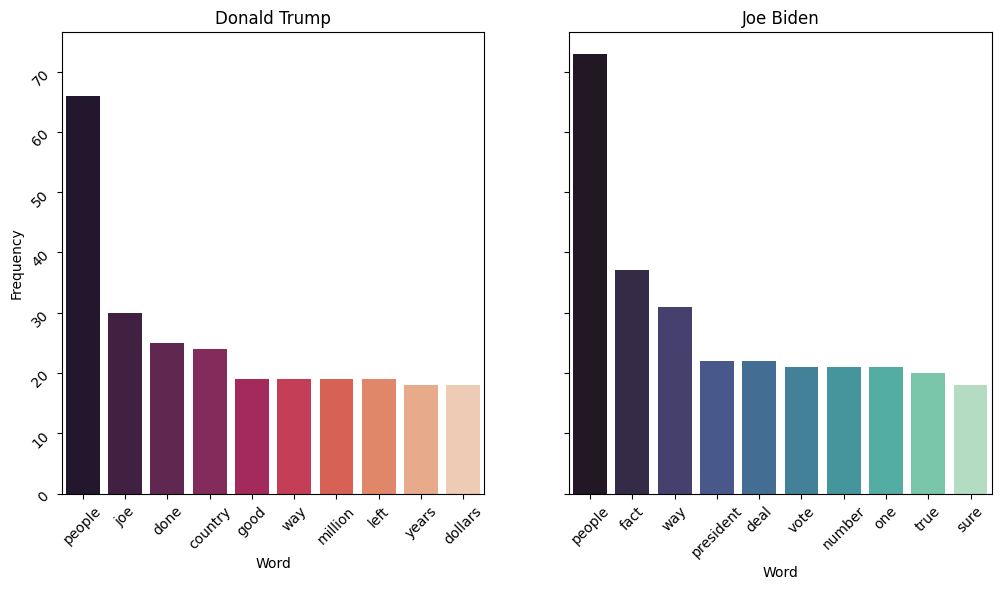

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
sns.barplot(data=df_trump, x='Word', y='Frequency', palette='rocket', ax=ax[0]).set_title('Donald Trump')
sns.barplot(data=df_biden, x='Word', y='Frequency', palette='mako', ax=ax[1]).set_title('Joe Biden')
ax[0].tick_params(labelrotation=45)
ax[1].tick_params(labelrotation=45)
fig.savefig('test2.jpg', bbox_inches='tight')

In [15]:
stop_words=stopwords.words('english')

X = data_raw['text']
y = data_raw['speaker']

print(y.value_counts(normalize=True))
y.value_counts()

speaker
President Donald J. Trump    0.557726
Vice President Joe Biden     0.442274
Name: proportion, dtype: float64


,count
speaker,
President Donald J. Trump,314
Vice President Joe Biden,249


In [16]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [17]:
le.classes_

array(['President Donald J. Trump', 'Vice President Joe Biden'],
      dtype=object)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=1)

tf_idf = TfidfVectorizer(stop_words=stop_words, lowercase=True)

bag_of_words_train = tf_idf.fit_transform(X_train)
bag_of_words_train_features = tf_idf.get_feature_names_out() # Use get_feature_names_out()
bag_of_words_train_df = pd.DataFrame(bag_of_words_train.toarray(), columns=bag_of_words_train_features)

bag_of_words_test = tf_idf.transform(X_test)
bag_of_words_test_features = tf_idf.get_feature_names_out() # Use get_feature_names_out()
bag_of_words_test_df = pd.DataFrame(bag_of_words_test.toarray(), columns=bag_of_words_test_features)

Multinomial Naive Bayes

In [20]:
kfold = StratifiedKFold(random_state=1, shuffle=True)

parameters_mnb = {
'alpha': np.linspace(0.01, 1, 10)
}

mnb = MultinomialNB()
grid_search_mnb = GridSearchCV(mnb, param_grid=parameters_mnb, scoring='accuracy')
grid_search_mnb.fit(bag_of_words_train_df, y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ])},
             scoring='accuracy')

In [21]:
y_pred_class_mnb = grid_search_mnb.predict(bag_of_words_test_df)
y_pred_score_classes_mnb = grid_search_mnb.predict_proba(bag_of_words_test_df)
y_pred_score_mnb = y_pred_score_classes_mnb[:, 1]

classif_report_mnb = classification_report(y_test, y_pred_class_mnb)
print(classif_report_mnb)

              precision    recall  f1-score   support

           0       0.68      0.85      0.76        79
           1       0.72      0.50      0.59        62

    accuracy                           0.70       141
   macro avg       0.70      0.67      0.67       141
weighted avg       0.70      0.70      0.68       141



In [22]:
confusion_matrix(y_test, y_pred_class_mnb)

array([[67, 12],
       [31, 31]])

Random Forest

In [23]:
rfc = RandomForestClassifier()
rfc.fit(bag_of_words_train_df, y_train)

y_pred_class_rfc = rfc.predict(bag_of_words_test_df)
y_pred_score_classes_rfc = rfc.predict_proba(bag_of_words_test_df)
y_pred_score_rfc = y_pred_score_classes_rfc[:, 1]

In [24]:
classif_report = classification_report(y_test, y_pred_class_rfc)
print(classif_report)

              precision    recall  f1-score   support

           0       0.68      0.85      0.76        79
           1       0.72      0.50      0.59        62

    accuracy                           0.70       141
   macro avg       0.70      0.67      0.67       141
weighted avg       0.70      0.70      0.68       141



In [25]:
confusion_matrix(y_test, y_pred_class_rfc)

array([[67, 12],
       [31, 31]])

In [26]:
accuracy_score(y_test, y_pred_class_rfc)

0.6950354609929078

0.7580645161290323


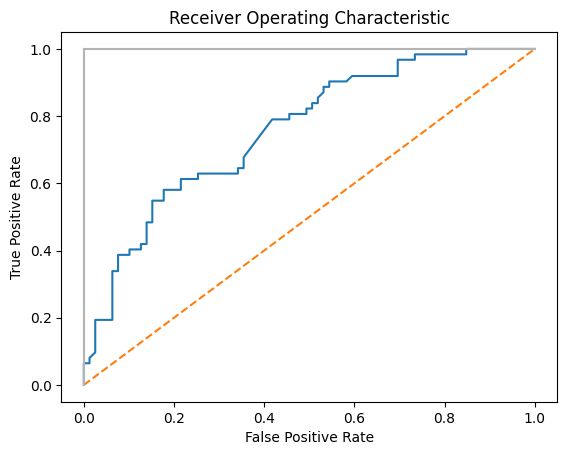

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_score_rfc)

print(roc_auc_score(y_test, y_pred_score_rfc))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Extreme Gradient Boosting

In [28]:
params_xgb = {
    "n_estimators": [50,100,500],
    "max_depth": [1,2,3,4],
    "learning_rate": [0.01, 0.1],
}

xgb = XGBClassifier(n_jobs=-1)
grid_search_xgb = GridSearchCV(xgb, param_grid=params_xgb, cv=kfold, verbose=1, n_jobs=-1)
grid_search_xgb.fit(bag_of_words_train_df, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [1, 2, 3, 4],
                         'n_estimators': [50, 100, 500]},
             verbose=1)

In [29]:
y_pred_class_xgb = grid_search_xgb.predict(bag_of_words_test_df)
y_pred_score_classes_xgb = grid_search_xgb.predict_proba(bag_of_words_test_df)
y_pred_score_xgb = y_pred_score_classes_xgb[:, 1]

classif_report = classification_report(y_test, y_pred_class_xgb)
print(classif_report)

              precision    recall  f1-score   support

           0       0.62      0.86      0.72        79
           1       0.66      0.34      0.45        62

    accuracy                           0.63       141
   macro avg       0.64      0.60      0.59       141
weighted avg       0.64      0.63      0.60       141



In [30]:
confusion_matrix(y_test, y_pred_class_xgb)

array([[68, 11],
       [41, 21]])